In [4]:
import os
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [5]:
parent = os.path.join(Path(os.getcwd()).parent)

sys.path.append(parent)

from utils.results import SimulationResults

First define soil parameters

In [12]:
# soil properties
rho_soil        = None   # [kg/m3] density soil, constant for frozen/unfrozen. If "None", density is calculated as "nb * rho_water + (1-nb) * rho_particle".
rho_particle    = 2650     # [kg/m3] particle density of soil, only used if "rho_soil = None"
nb_min          = 0.45     # [-] minimum ground ice content (Ravens et al, 2023: 0.65 - 0.45)
nb_max          = 0.65     # [-] maximum ground ice content (Ravens et al, 2023: 0.65 - 0.45)
nb_min_depth    = 1.5      # [m] end switch from max to min porosity (adapted from Ravens, thermal model)
nb_max_depth    = 0.5      # [m] start switch from max to min porosity (adapted from Ravens, thermal model)
c_soil_frozen   = 4600000  # [J/K/m3] volumetric heat capacity for frozen soil (Ravens et al, 2023)  ( = specific heat capacity)
c_soil_unfrozen = 7000000  # [J/K/m3] volumetric heat capacity for unfrozen soil (Ravens et al, 2023)
k_soil_frozen_min   = 0.7  # [W/m/K] minimum thermal conductivity for frozen soil (Ravens et al, 2023: 0.7 - 2.7)
k_soil_frozen_max   = 2.7  # [W/m/K] maximum thermal conductivity for frozen soil (Ravens et al, 2023: 0.7 - 2.7)
k_soil_unfrozen_min = 0.6  # [W/m/K] minimum thermal conductivity for unfrozen soil (Ravens et al, 2023: 0.6 - 1.5)
k_soil_unfrozen_max = 1.5  # [W/m/K] maximum thermal conductivity for unfrozen soil (Ravens et al, 2023: 0.6 - 1.5)
depth_constant_k    = 1.0  # [m] depth at which k reaches its maximum value. k remains constant below this depth (Ravens, MATLAB script)
geothermal_gradient = 0.025  # [K/m] geothermal gradient, used as the boundary condition at the bottom of each 1D model

And define the grid

In [13]:
N = 1500
max_depth = 15

thermal_zgr = np.linspace(0, max_depth, N)

Compute distributions

In [14]:
id_kmax = np.argmin(np.abs(thermal_zgr - depth_constant_k))  # id of the grid point at which the maximum k should be reached
k_unfrozen_distr = np.append(
    np.linspace(
        k_soil_unfrozen_min, 
        k_soil_unfrozen_max,
        len(thermal_zgr[:id_kmax])), 
    np.ones(len(thermal_zgr[id_kmax:])) * k_soil_unfrozen_max)
k_frozen_distr = np.append(
    np.linspace(
        k_soil_frozen_min, 
        k_soil_frozen_max,
        len(thermal_zgr[:id_kmax])), 
    np.ones(len(thermal_zgr[id_kmax:])) * k_soil_frozen_max)



def k(x, k_min, k_max):
    
    return k_max - (k_max - k_min) * np.exp(-x)

k_frozen_distr2 = k(thermal_zgr, k_soil_frozen_min, k_soil_frozen_max)



In [15]:
nb = np.zeros(N)
z = np.linspace(0, max_depth, N)

mid = (nb_max_depth + nb_min_depth) / 2
        
nb = (1 / (1 + np.exp(-(z - mid) * 10 / (nb_min_depth - nb_max_depth)))) * (nb_min - nb_max) + nb_max

nb[np.argwhere(z<=nb_max_depth)] = nb_max
nb[np.argwhere(z>=nb_min_depth)] = nb_min

In [16]:
particle_density = 2650
water_density = 1000

rho = nb * water_density + (1 - nb) * particle_density

And plot

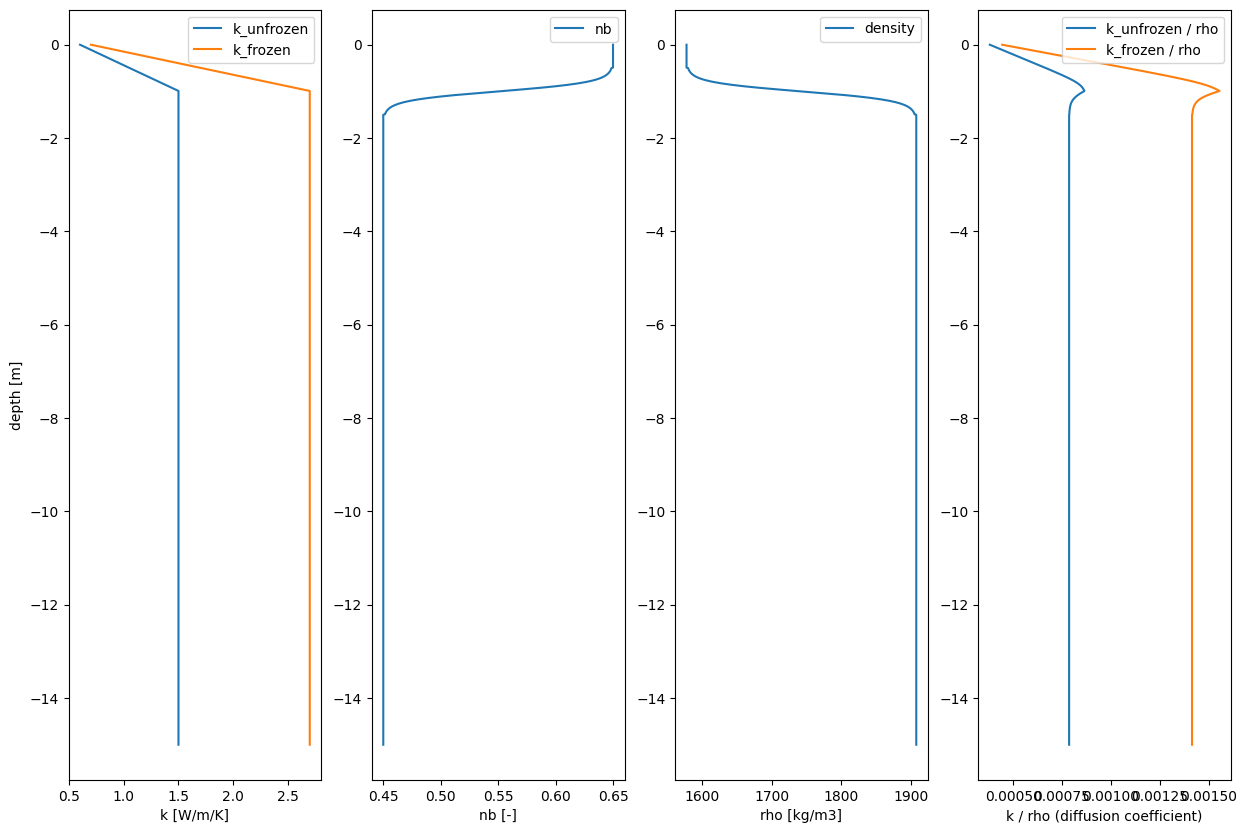

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(15, 10))
ax1, ax2, ax3, ax4 = axs

ax1.plot(k_unfrozen_distr, -thermal_zgr, label='k_unfrozen')
ax1.plot(k_frozen_distr, -thermal_zgr, label='k_frozen')
# ax1.plot(k_frozen_distr2, -thermal_zgr, label='k_param')

ax2.plot(nb, -thermal_zgr, label='nb')

ax3.plot(rho, -thermal_zgr, label='density')

ax4.plot(k_unfrozen_distr / rho, -thermal_zgr, label='k_unfrozen / rho')
ax4.plot(k_frozen_distr / rho, -thermal_zgr, label='k_frozen / rho')
# ax4.plot(k_frozen_distr2 / rho, -thermal_zgr, label='k_param / rho')

ax1.set_ylabel('depth [m]')

ax1.set_xlabel('k [W/m/K]')
ax2.set_xlabel('nb [-]')
ax3.set_xlabel('rho [kg/m3]')
ax4.set_xlabel('k / rho (diffusion coefficient)')

for ax in axs:
    ax.legend(loc='best')
    # ax.set_ylim((-3, 0))
    

plt.show()